In [1]:
using StatisticalRethinking, Turing
gr(size=(500,500));

Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

┌ Info: Recompiling stale cache file /Users/rob/.julia/compiled/v1.2/StatisticalRethinking/zZGTK.ji for StatisticalRethinking [2d09df54-9d0f-5258-8220-54c2a3d4fbee]
└ @ Base loading.jl:1184


loaded


┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/0dgDY/src/Turing.jl:81


### snippet 4.43

In [2]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults and center the weight observations

In [3]:
df2 = filter(row -> row[:age] >= 18, df);
mean_weight = mean(df2[:weight]);
df2[:weight_c] = df2[:weight] .- mean_weight;
first(df2, 5)

,height,weight,age,male,weight_c
,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Float64
1,151.765,47.8256,63.0,1,2.83512
2,139.7,36.4858,63.0,0,-8.50468
3,136.525,31.8648,65.0,0,-13.1256
4,156.845,53.0419,41.0,1,8.05143
5,145.415,41.2769,51.0,0,-3.71361


Extract variables for Turing model

In [4]:
y = convert(Vector{Float64}, df2[:height]);
x = convert(Vector{Float64}, df2[:weight_c]);

Define the regression model

In [5]:
@model line(y, x) = begin
    #priors
    alpha ~ Normal(178.0, 100.0)
    beta ~ Normal(0.0, 10.0)
    s ~ Uniform(0, 50)

    #model
    mu = alpha .+ beta*x
    for i in 1:length(y)
      y[i] ~ Normal(mu[i], s)
    end
end;

Draw the samples

In [6]:
samples = 5000
adapt_cycles = 1000

@time chn = sample(line(y, x), Turing.NUTS(samples, adapt_cycles, 0.65));
draws = adapt_cycles:samples

┌ Info: [Turing] looking for good initial eps...
└ @ Turing /Users/rob/.julia/packages/Turing/0dgDY/src/samplers/support/hmc_core.jl:246
[NUTS{Turing.FluxTrackerAD,Union{}}] found initial ϵ: 0.000390625
└ @ Turing /Users/rob/.julia/packages/Turing/0dgDY/src/samplers/support/hmc_core.jl:291
┌ Warning: Numerical error has been found in gradients.
└ @ Turing /Users/rob/.julia/packages/Turing/0dgDY/src/core/ad.jl:154
┌ Warning: grad = [-0.868951, 2.91199, NaN]
└ @ Turing /Users/rob/.julia/packages/Turing/0dgDY/src/core/ad.jl:155
┌ Info:  Adapted ϵ = 0.041860226335948374, std = [1.0, 1.0, 1.0]; 1000 iterations is used for adaption.
└ @ Turing /Users/rob/.julia/packages/Turing/0dgDY/src/samplers/adapt/adapt.jl:91


[NUTS] Finished with
  Running time        = 485.25370896200036;
  #lf / sample        = 0.002;
  #evals / sample     = 22.1268;
  pre-cond. metric    = [1.0, 1.0, 1.0].
493.649833 seconds (3.66 G allocations: 239.349 GiB, 17.16% gc time)


1000:5000

Describe the chain result

In [7]:
describe(chn)

Iterations = 1:5000
Thinning interval = 1
Chains = 1
Samples per chain = 5000

Empirical Posterior Estimates:
              Mean           SD        Naive SE        MCSE         ESS    
   alpha   153.47123243   9.12967259 0.1291130680  1.0267480488   79.064701
    beta     0.90591051   0.07815896 0.0011053346  0.0010737306 5000.000000
  lf_num     0.00200000   0.14142136 0.0020000000  0.0020000000 5000.000000
       s     5.76486187   4.57685223 0.0647264649  0.6029141598   57.626576
 elapsed     0.09705074   0.11271063 0.0015939690  0.0019873894 3216.353938
 epsilon     0.05318071   0.10149160 0.0014353079  0.0072827072  194.211293
      lp -1104.09161228 158.14864994 2.2365596562 18.1730731871   75.731093
eval_num    22.12680000  17.73624641 0.2508284022  0.3240256276 2996.157964
  lf_eps     0.05318071   0.10149160 0.0014353079  0.0072827072  194.211293

Quantiles:
               2.5%           25.0%           50.0%           75.0%           97.5%     
   alpha   146.939752779   15

Show corrected results (drop adaptation samples)

In [8]:
for var in [:alpha, :beta, :s]
  describe(chn[Symbol(var)][draws])
  println("$var = ",  mean_and_std(chn[Symbol(var)][draws]))
end

Summary Stats:
Mean:           154.588156
Minimum:        153.622115
1st Quartile:   154.419013
Median:         154.586628
3rd Quartile:   154.777065
Maximum:        155.549980
Length:         4001
Type:           Float64
alpha = (154.58815597694613, 0.2563223512827998)
Summary Stats:
Mean:           0.905479
Minimum:        0.760774
1st Quartile:   0.876522
Median:         0.905549
3rd Quartile:   0.933571
Maximum:        1.045151
Length:         4001
Type:           Float64
beta = (0.9054792962537588, 0.042667112964585974)
Summary Stats:
Mean:           5.103198
Minimum:        4.363082
1st Quartile:   4.968124
Median:         5.094436
3rd Quartile:   5.233923
Maximum:        5.921219
Length:         4001
Type:           Float64
s = (5.103197848095711, 0.19675670369150214)


Compare with a previous result

In [9]:
clip_43s_example_output = "

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
alpha 154.597086 0.27326431 0.0043206882 0.0036304132 1000
 beta   0.906380 0.04143488 0.0006551430 0.0006994720 1000
sigma   5.106643 0.19345409 0.0030587777 0.0032035103 1000

Quantiles:
          2.5%       25.0%       50.0%       75.0%       97.5%
alpha 154.0610000 154.4150000 154.5980000 154.7812500 155.1260000
 beta   0.8255494   0.8790695   0.9057435   0.9336445   0.9882981
sigma   4.7524368   4.9683400   5.0994450   5.2353100   5.5090128
";

Plot the regerssion line and observations

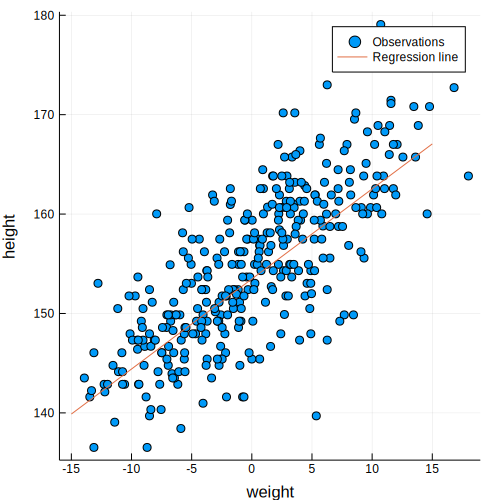

In [10]:
scatter(x, y, lab="Observations", xlab="weight", ylab="height")
xi = -15.0:0.1:15.0
yi = mean(chn[:alpha]) .+ mean(chn[:beta])*xi
plot!(xi, yi, lab="Regression line")

End of `clip_43t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*